# 1- Setup enviroment

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import sklearn
import xgboost
import hyperopt
import shap

import matplotlib

In [2]:
print('-'*16)
print('*** Versions ***')
print('-'*16)
print(f'pandas=={pd.__version__}')
print(f'numpy=={np.__version__}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'sklearn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')
print(f'hyperopt=={hyperopt.__version__}')
print(f'shap=={shap.__version__}')

----------------
*** Versions ***
----------------
pandas==1.5.3
numpy==1.23.5
matplotlib==3.6.2
sklearn==1.3.0
xgboost==1.7.3
hyperopt==0.2.7
shap==0.41.0


In [3]:
# -----------DEFINE DEFAULT PARAMETERS OF MATPLOTLIB---------------
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 0.5
# -----------------------------------------------------------------

# 2- Meet and greet data

In [4]:
train_df =  pd.read_csv('../data/raw/train.csv',index_col='id')
test_df =  pd.read_csv('../data/raw/test.csv',index_col='id')
sample_df = pd.read_csv('../data/raw/sample_submission.csv')

In [5]:
train_df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


# 2- EDA

## 2.1 Lazy Auto EDA

In [8]:
#profile = ProfileReport(train_df,title='Profiling Report')
#profile.to_notebook_iframe()

## 2.2 - Conventional EDA

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.6+ MB


In [7]:
print('Unique values [train_df]:')
train_df.nunique(dropna=True).to_frame().transpose()

Unique values [train_df]:


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,9976,3,95,81,952,611,246,2,2,2,2,2,2


In [8]:
print('Unique values [test_df]:')
test_df.nunique(dropna=True).to_frame().transpose()

Unique values [test_df]:


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,9909,3,92,84,946,595,246,2,2,2,2,2


In [9]:
print('Missing values [train_df]:')
train_df.isna().sum().to_frame().transpose()

Missing values [train_df]:


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
print('Missing values [test_df]:')
test_df.isna().sum().to_frame().transpose()

Missing values [test_df]:


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,0,0,0,0,0,0,0,0,0,0,0,0


### 2.2.1 Distributions

In [11]:
# Features type
cat_ft = 'Type'
num_ft = ['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
bin_ft = ['TWF','HDF','PWF','OSF','RNF']
target = 'Machine failure'
machine = 'Product ID'

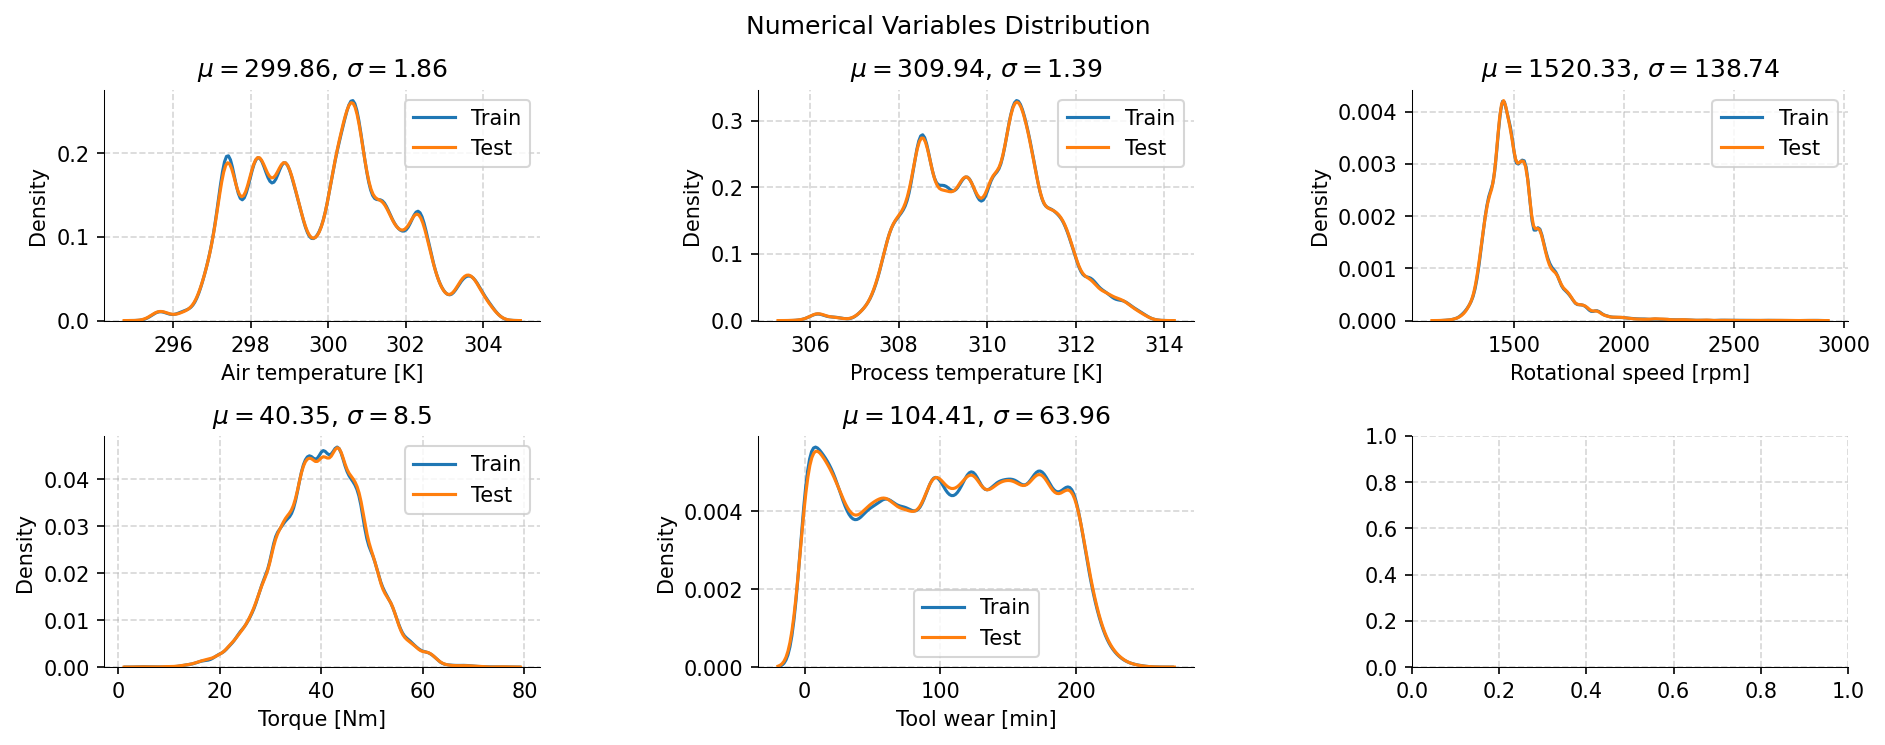

In [12]:
def ceildiv(a, b):
    """
    Calculate the ceiling division of two numbers.

    Parameters:
    a (int): Numerator.
    b (int): Denominator.

    Returns:
    int: Result of ceiling division.
    """
    return -(a // -b)

def plot_hist(train_df, test_df, features, n_cols=3):
    """
    Plot kernel density estimates (KDE) for the distribution of numerical features in training and test datasets.

    Parameters:
    train_df (pd.DataFrame): Training dataset.
    test_df (pd.DataFrame): Test dataset.
    features (list): List of numerical features to plot.
    n_cols (int): Number of columns for subplot grid. Default is 3.

    Returns:
    None
    """
    
    n_graphs = len(features)
    n_rows = ceildiv(n_graphs,n_cols) # Calculate number of subplot rows
    
    fig, axs = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(15,5))
    axs =  axs.flatten()
    
    for index in range(n_graphs):
        ax = axs[index]
        feat = features[index]
        mu_train = round(train_df[feat].mean(),2) # Calculate mean
        sigma_train = round(np.std(train_df[feat]),2) # Calculate standard deviation
        
        sns.kdeplot(data=train_df,x=feat,ax=ax,label='Train')
        sns.kdeplot(data=test_df,x=feat,ax=ax,label='Test')
        
        ax.title.set_text(f'$\mu=${mu_train}, $\sigma=${sigma_train}')
        ax.legend()
        
    plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.suptitle('Numerical Variables Distribution')
    plt.show()
    
plot_hist(train_df,test_df,features=num_ft)

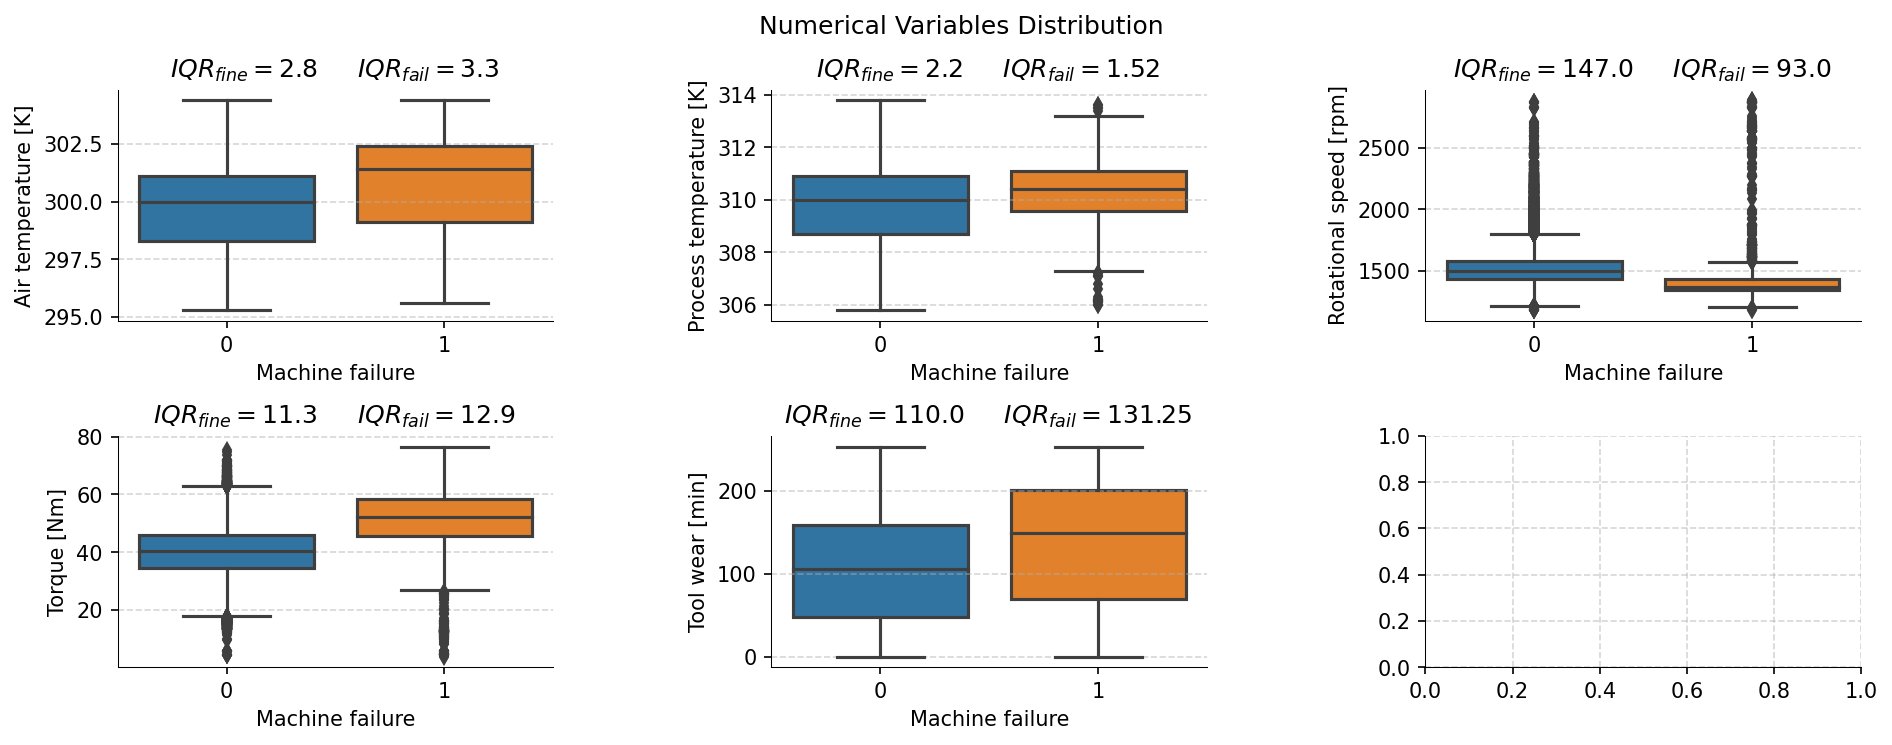

In [13]:
def plot_box(train_df, test_df, features, target, n_cols=3):
    """
    Plot box plots for the distribution of numerical features based on target variable classes.

    Parameters:
    train_df (pd.DataFrame): Training dataset.
    test_df (pd.DataFrame): Test dataset.
    features (list): List of numerical features to plot.
    target (str): Name of the target variable.
    n_cols (int): Number of columns for subplot grid. Default is 3.

    Returns:
    None
    """
    
    n_graphs = len(features)
    n_rows = ceildiv(n_graphs,n_cols)
    
    fig, axs = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(15,5))
    axs =  axs.flatten()
    
    for index in range(n_graphs):
        ax = axs[index]
        feat = features[index]
        
        # Calculate IQR for target classes (Only binary clasification)
        q1_fine = train_df[train_df[target] == 0][feat].quantile(0.25)
        q3_fine = train_df[train_df[target] == 0][feat].quantile(0.75)
        iqr_fine = round(q3_fine - q1_fine,2)
        
        q1_fail = train_df[train_df[target] == 1][feat].quantile(0.25)
        q3_fail = train_df[train_df[target] == 1][feat].quantile(0.75)
        iqr_fail = round(q3_fail - q1_fail,2)
        
        sns.boxplot(data=train_df,y=feat,x=target,ax=ax)
        
        ax.title.set_text('$IQR_{fine}=$'+f'{iqr_fine}'+'     '+'$IQR_{fail}=$'+f'{iqr_fail} ')
        
    plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.suptitle('Numerical Variables Distribution')
    plt.show()
    
plot_box(train_df,test_df,features=num_ft,target=target)

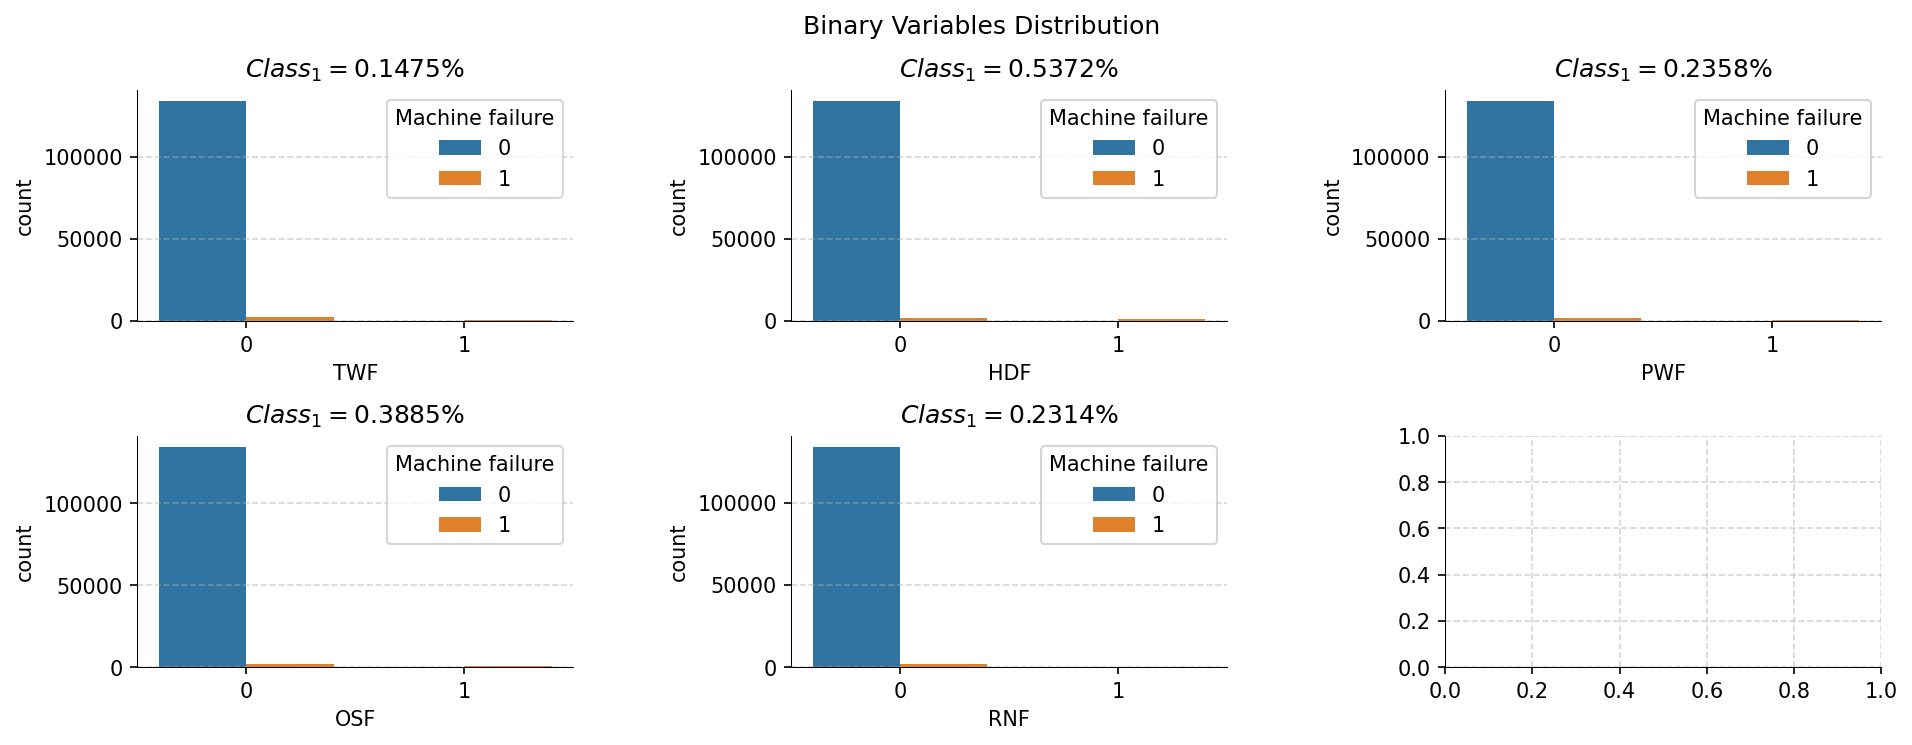

In [14]:
def plot_count(train_df, test_df, features, target, n_cols=3):
    """
    Plot count plots for the distribution of binary features based on target variable classes.

    Parameters:
    train_df (pd.DataFrame): Training dataset.
    test_df (pd.DataFrame): Test dataset.
    features (list): List of binary features to plot.
    target (str): Name of the target variable.
    n_cols (int): Number of columns for subplot grid. Default is 3.

    Returns:
    None
    """
    
    n_graphs = len(features)
    n_rows = ceildiv(n_graphs,n_cols)
    
    fig, axs = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(15,5))
    axs =  axs.flatten()
    
    for index in range(n_graphs):
        ax = axs[index]
        feat = features[index]
        
        # Calculate percentage of class 1 occurrences in the binary feature
        perc = (test_df[feat] == 1).sum() / (test_df[feat] == 0).sum() * 100
        perc = round(perc,4)
        
        sns.countplot(data=train_df,x=feat,hue=target,ax=ax)
        
        ax.title.set_text(f'$Class_1=${perc}%')
        
    plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.suptitle('Binary Variables Distribution')
    plt.show()
    
plot_count(train_df,test_df,features=bin_ft,target=target)

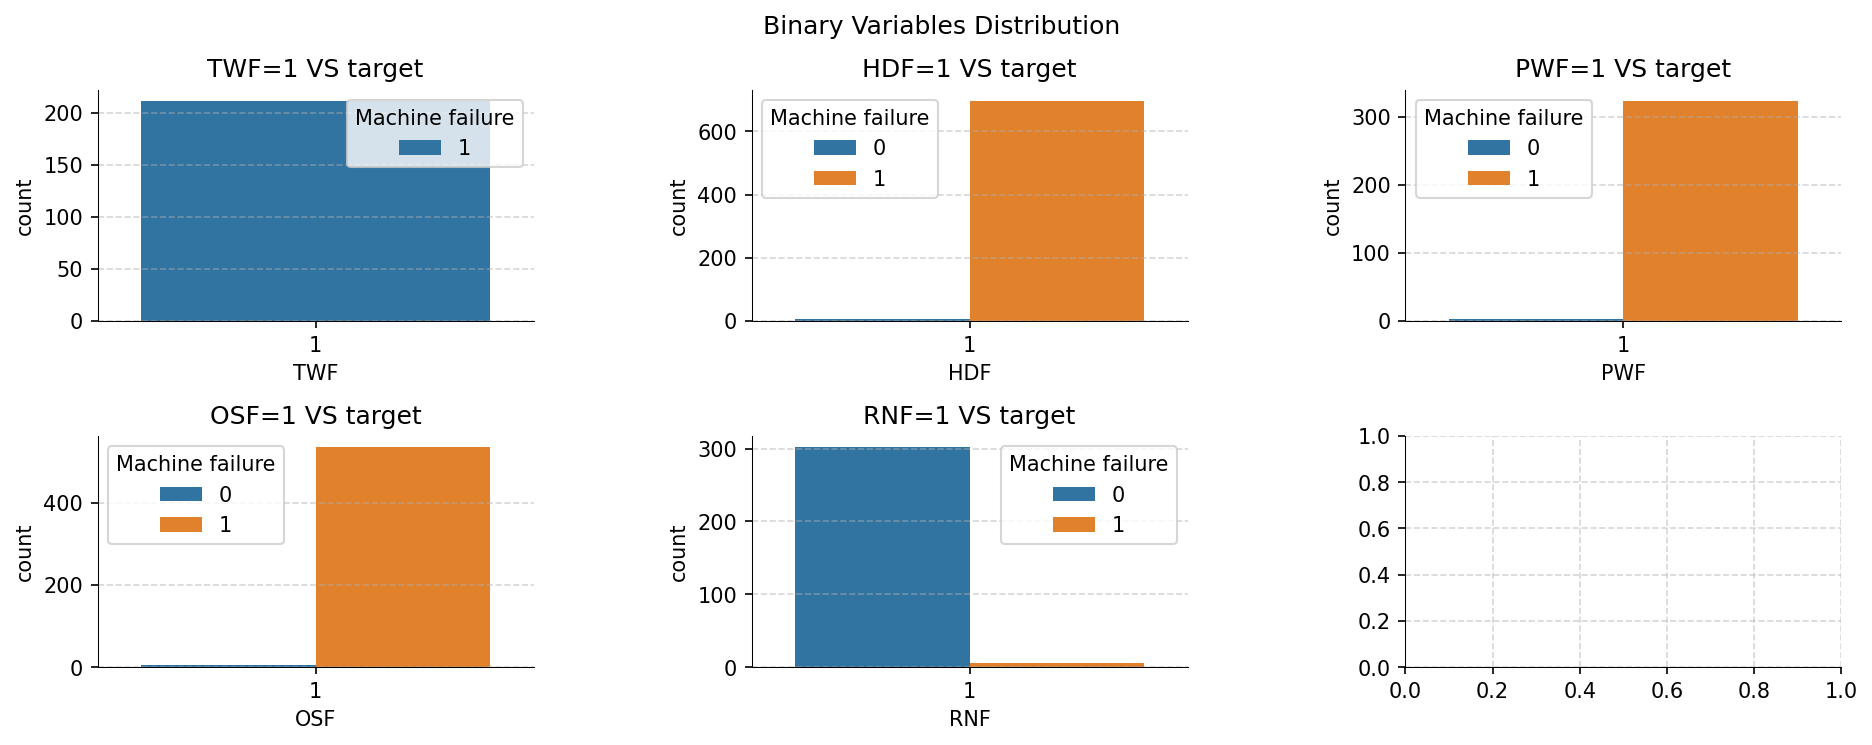

In [15]:
def plot_count_target(train_df, test_df, features, target, n_cols=3):
    """
    Plot count plots for the distribution of binary features with value 1 based on target variable classes.

    Parameters:
    train_df (pd.DataFrame): Training dataset.
    test_df (pd.DataFrame): Test dataset.
    features (list): List of binary features to plot.
    target (str): Name of the target variable.
    n_cols (int): Number of columns for subplot grid. Default is 3.

    Returns:
    None
    """
    
    n_graphs = len(features)
    n_rows = ceildiv(n_graphs,n_cols)
    
    fig, axs = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(15,5))
    axs =  axs.flatten()
    
    for index in range(n_graphs):
        ax = axs[index]
        feat = features[index]
        
        # Filter data with feature value 1
        data = train_df[train_df[feat] == 1]
        
        sns.countplot(data=data,x=feat,hue=target,ax=ax)
        
        ax.title.set_text(f'{feat}=1 VS target')
        
    plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.suptitle('Binary Variables Distribution')
    plt.show()
    
plot_count_target(train_df,test_df,features=bin_ft,target=target)

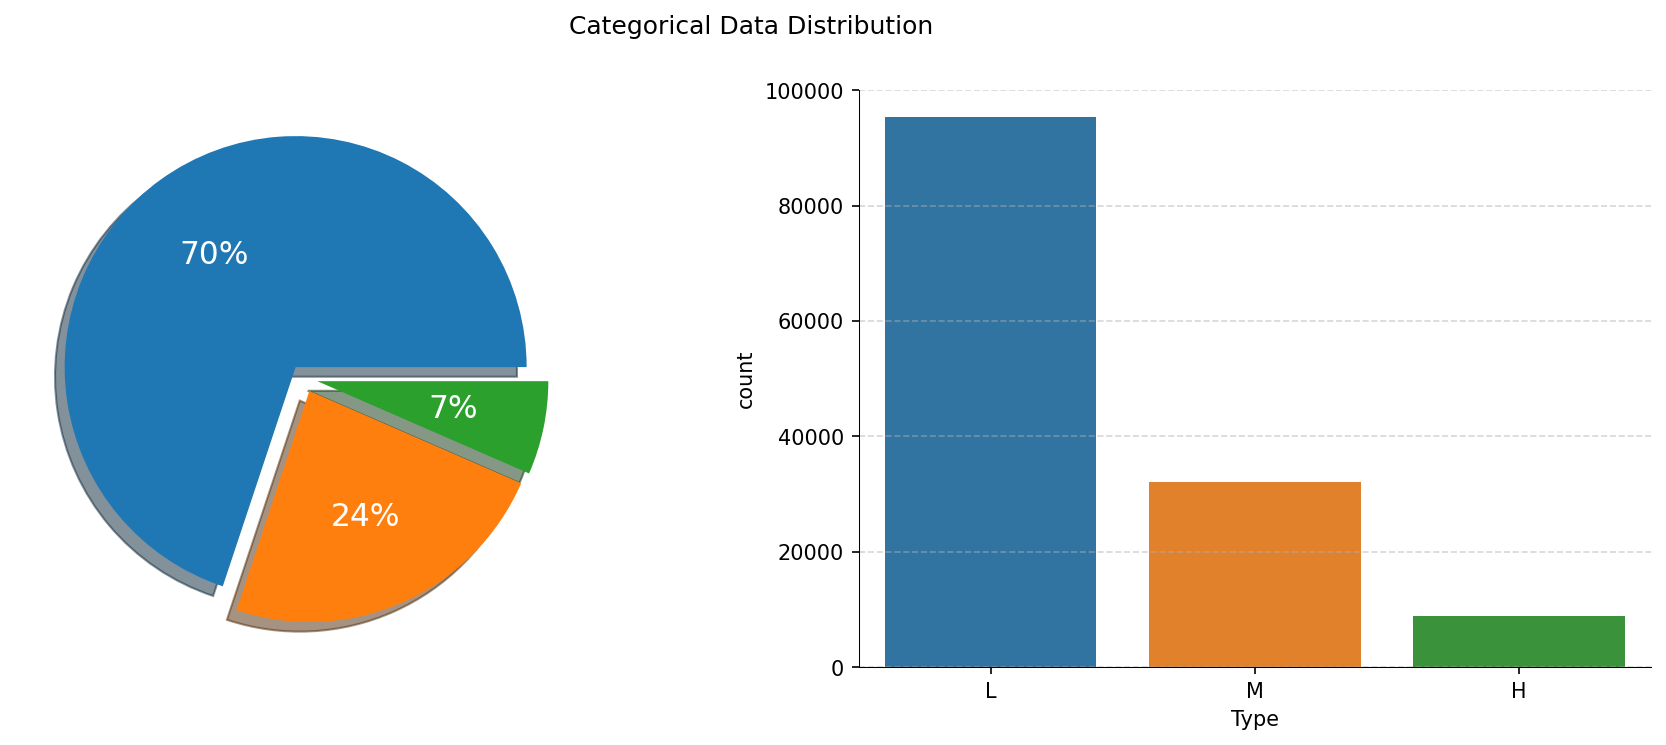

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax = ax.flatten()

ax[0].pie(train_df[cat_ft].value_counts(),
          shadow=True,
          explode=[0.06] * len(train_df[cat_ft].unique()),
          autopct='%1.f%%',
          textprops={'size': 15, 'color': 'white'},)

ax[0].set_aspect('equal')

sns.countplot(data=train_df,x=cat_ft,ax=ax[1])

fig.suptitle('Categorical Data Distribution')
plt.show()

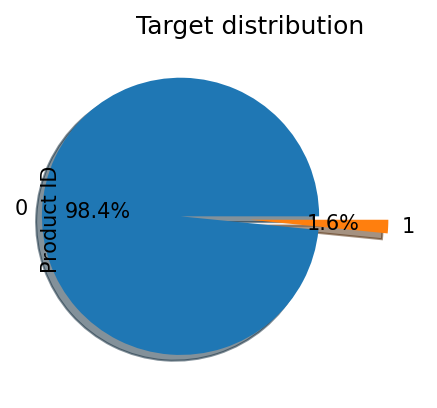

In [17]:
plt.figure(figsize=(3,3))
train_df.groupby('Machine failure').count()['Product ID'].plot.pie(title='Target distribution', 
                                                                   autopct='%1.1f%%', 
                                                                   shadow=True, 
                                                                   explode=(0.5, 0))
plt.show()

### 2.2.2 Correlations

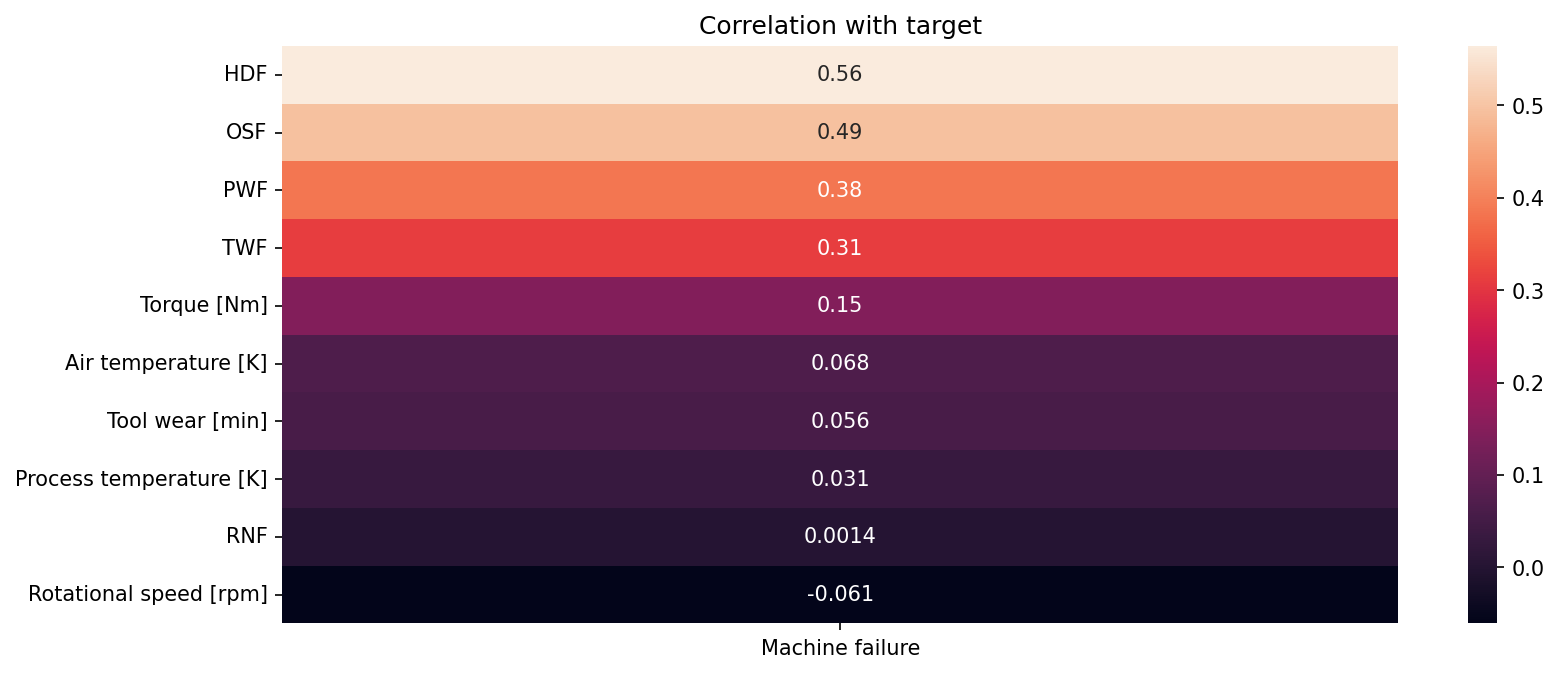

In [18]:
def corr_target(data,feats,target):
    """
    Plot a heatmap to show the correlation of features with the target variable.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data.
    feats (list): List of feature names to calculate correlation with target.
    target (str): Name of the target variable.

    Returns:
    None
    """
    
    heat_data = data[feats + [target]].corr()[target].sort_values(ascending=False)[1:].to_frame()
    
    sns.heatmap(data=heat_data,annot=True)
    
    plt.title('Correlation with target')
    plt.show()


corr_target(train_df,num_ft + bin_ft,target)

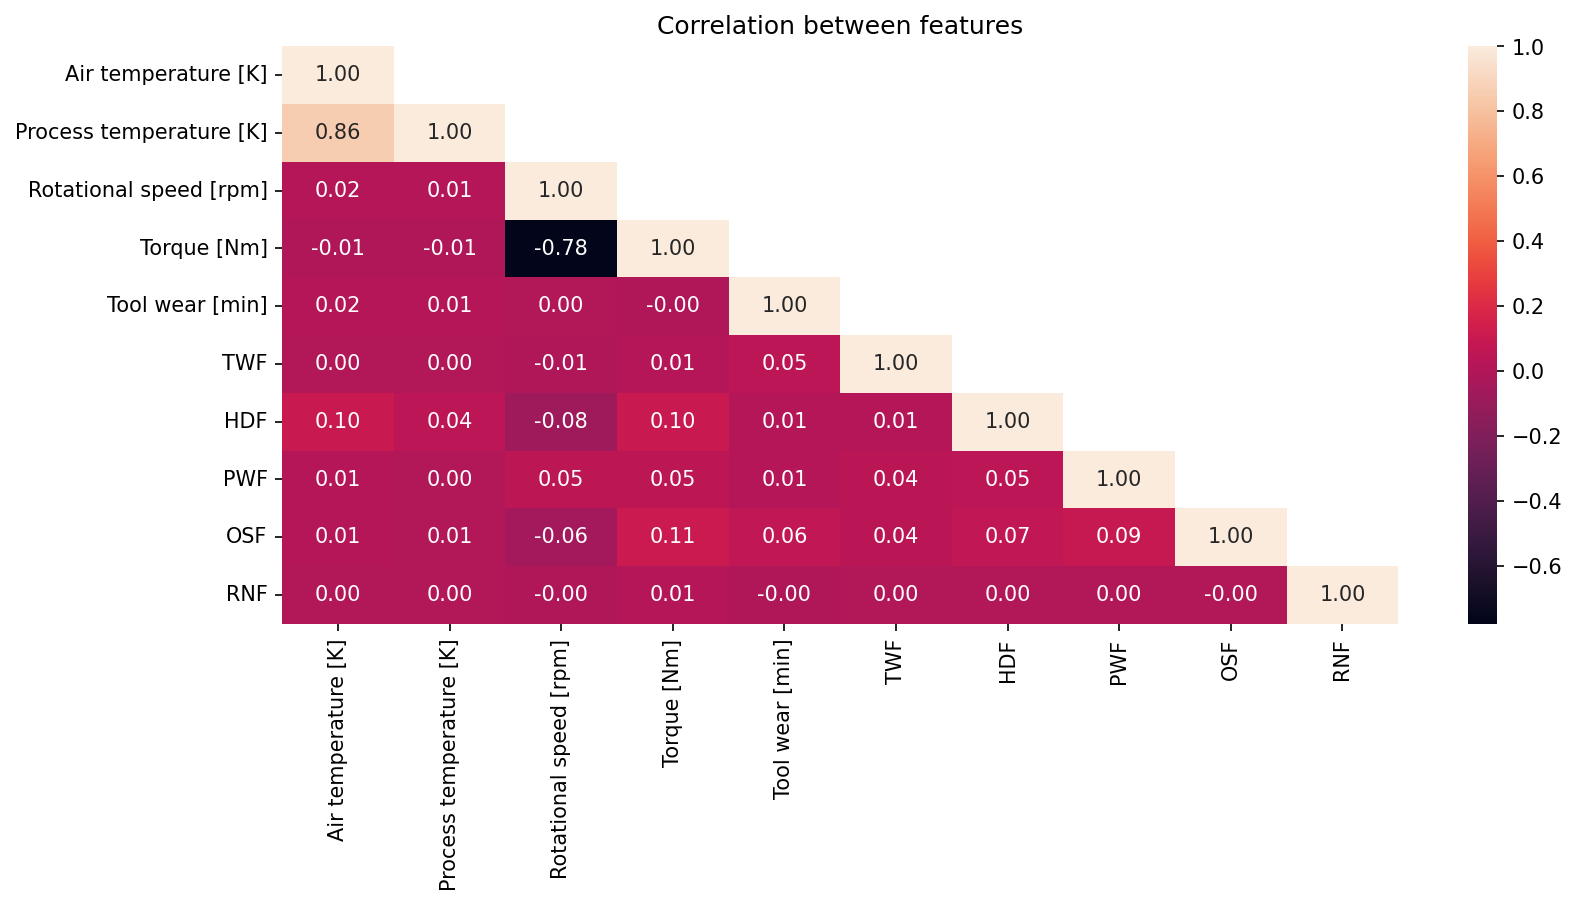

In [19]:
def corr_feat(data):
    """
    Plot a heatmap to show the correlation between features in the dataset.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data.

    Returns:
    None
    """
    
    corr_matrix = data.corr()
    
    # Create a mask to hide the upper triangle of the correlation matrix
    mask = np.triu(np.ones_like(corr_matrix,dtype=bool), k=1)
    corr_matrix = corr_matrix.mask(mask) # Apply the mask to hide upper triangle
    
    sns.heatmap(data=corr_matrix,annot=True, fmt='.2f')
    
    plt.title('Correlation between features')
    plt.show()

corr_feat(train_df[num_ft + bin_ft])

In [22]:
#sns.pairplot(data=train_df[num_ft + [target]],hue=target,corner=True,plot_kws={'alpha': 0.3}, diag_kws={'alpha': 0.5})
#plt.show()

In [ ]:
train_df['Process temperature [K]']

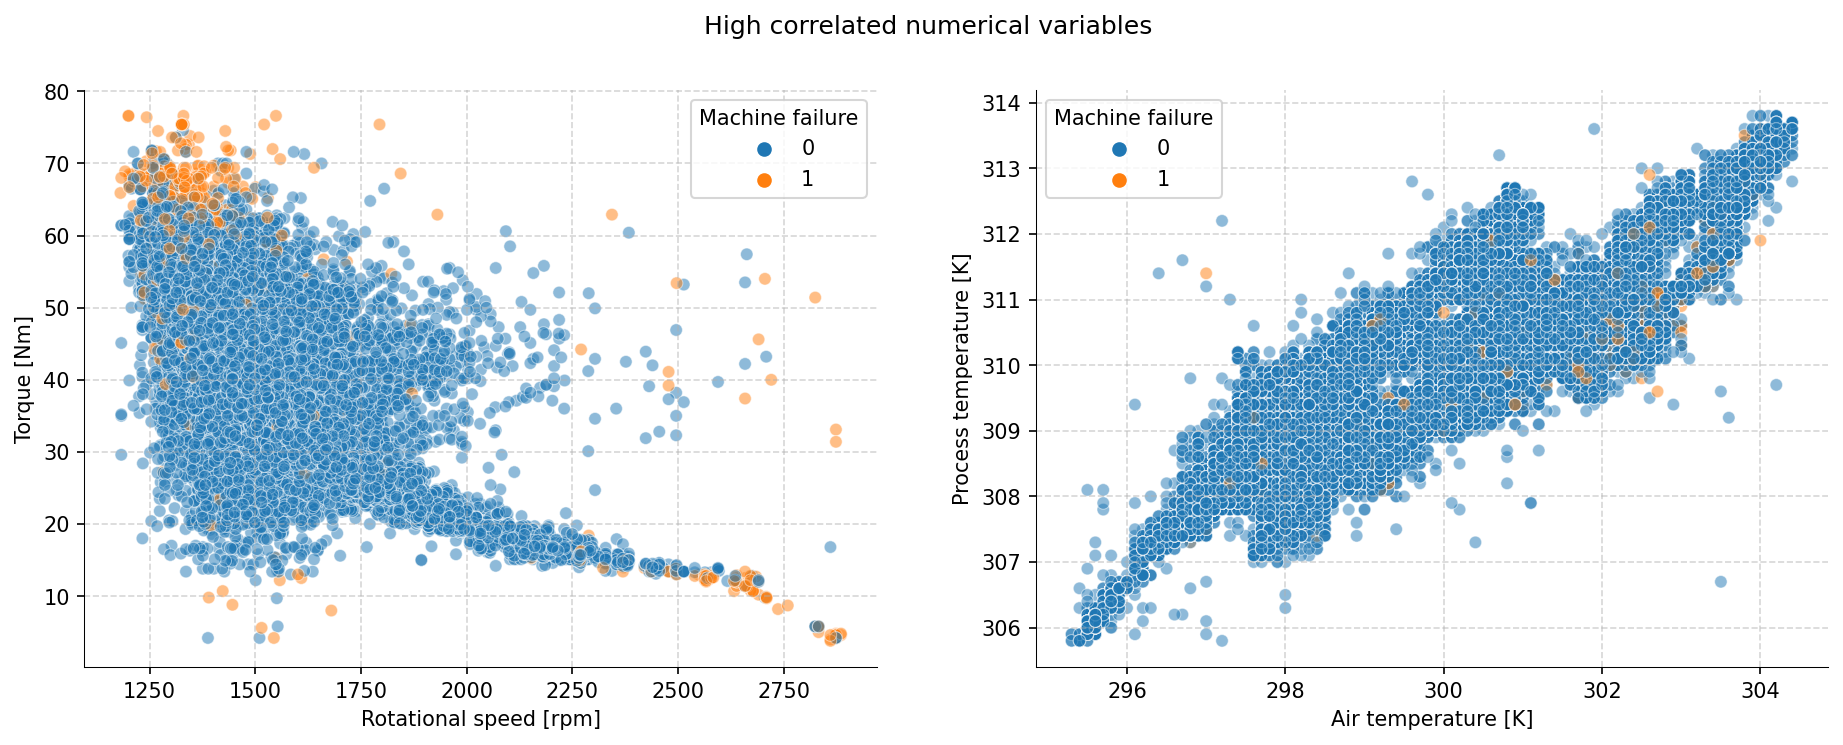

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax = ax.flatten()

sns.scatterplot(data=train_df,x='Rotational speed [rpm]', y='Torque [Nm]', hue=target, alpha=0.5, ax=ax[0])
sns.scatterplot(data=train_df,x='Air temperature [K]', y='Process temperature [K]', hue=target, alpha=0.5, ax=ax[1])

fig.suptitle('High correlated numerical variables')
plt.show()

## 3- Feature Engineering

**Strategy**:
- Fill values (possibly existing in unseen data)
- Standardization
- Encode categorical data
- Feature creation

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
encoder = OrdinalEncoder()

# TODO: sklearn pipeline
def feature_pipeline(df,catf,binf,numf):
    df = df.copy()
    
    # Impute missing values and scale numerical features
    df[numf] = num_imputer.fit_transform(df[numf])
    df[numf] = scaler.fit_transform(df[numf])
    
    # Impute missing values and encode categorical and binary features
    df[[catf] + binf] = cat_imputer.fit_transform(df[[catf] + binf])
    df[catf] = encoder.fit_transform(df[[catf]])
    
    # Convert again to Binary (int)
    for feat in binf:
        df[feat] = df[feat].astype('int')
    
    # Encode the 'machine' feature
    df[machine] = encoder.fit_transform(df[[machine]])
    
    # Create new features based on combinations of existing features
    df['Temperature ratio'] = df['Process temperature [K]'] * df['Air temperature [K]']
    df['Mechanical ratio'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']
    
    # Required for XGBoost
    new_colums = []
    for name in df.columns:
        new_colums.append(name.replace('[','(').replace(']',')'))
    df.columns = new_colums
    
    return df
    
train_trans_df = feature_pipeline(train_df,cat_ft,bin_ft,num_ft)
train_trans_df.head()

,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Machine failure,TWF,HDF,PWF,OSF,RNF,Temperature ratio,Mechanical ratio
id,,,,,,,,,,,,,,,
0,2752.0,1.0,0.395880,-0.246230,0.545416,-0.499711,0.556417,0,0,0,0,0,0,-0.097478,-0.272550
1,8620.0,2.0,1.469856,1.558605,1.720308,-1.323028,1.494433,0,0,0,0,0,0,2.290924,-2.276015
2,2344.0,1.0,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,0,0,0,0,0,0,0.314400,-3.342154
3,4704.0,1.0,0.610675,0.692284,0.026445,0.464745,1.447532,0,0,0,0,0,0,0.422761,0.012290
4,9727.0,2.0,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,0,0,0,0,0,0,0.679586,-0.506245


In [25]:
train_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136429 entries, 0 to 136428
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  float64
 1   Type                     136429 non-null  float64
 2   Air temperature (K)      136429 non-null  float64
 3   Process temperature (K)  136429 non-null  float64
 4   Rotational speed (rpm)   136429 non-null  float64
 5   Torque (Nm)              136429 non-null  float64
 6   Tool wear (min)          136429 non-null  float64
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int32  
 9   HDF                      136429 non-null  int32  
 10  PWF                      136429 non-null  int32  
 11  OSF                      136429 non-null  int32  
 12  RNF                      136429 non-null  int32  
 13  Temperature ratio        136429 non-null  float64
 14  Mech

# 4- Modeling

## 4.1 Data split

In [26]:
from sklearn.model_selection import train_test_split

X = train_trans_df.drop(target,axis=1)
y = train_trans_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f'Train ds shape: {X_train.shape}')
print(f'Validation ds shape: {X_val.shape}')
print(f'Test ds shape: {X_test.shape}')

Train ds shape: (109143, 14)
Validation ds shape: (13643, 14)
Test ds shape: (13643, 14)


## 4.2 Model evaluation

In [24]:
from sklearn.model_selection import cross_validate

def alg_ev_cross(models,X_train,y_train,cv=10):
    """
    Evaluate the performance of classification models using cross-validation.

    Parameters:
        models (list): List of classification models to evaluate.
        X_train (array-like): Training data features.
        y_train (array-like): Training data target.
        cv (int, optional): Number of cross-validation folds. Default is 10.

    Returns:
        DataFrame: Evaluation results containing algorithm name, training time,
                   accuracy, balanced accuracy, F1 score, precision, and recall.

    """
    scoring = ['accuracy','balanced_accuracy', 'f1', 'precision', 'recall']
    name = []
    fit_time = []
    test_accuracy = []
    test_balanced_accuracy = []
    test_f1 = []
    test_precision = []
    test_recall = []

    for model in models:
        # Perform cross-validation and calculate scores
        scores = cross_validate(model,X_train,y_train,cv=cv,scoring=scoring)
        
        # Collect algorithm name and average scores
        name.append(model.__class__.__name__)
        fit_time.append(np.mean(scores['fit_time']))
        test_accuracy.append(np.mean(scores['test_accuracy']))
        test_balanced_accuracy.append(np.mean(scores['test_balanced_accuracy']))
        test_f1.append(np.mean(scores['test_f1']))
        test_precision.append(np.mean(scores['test_precision']))
        test_recall.append(np.mean(scores['test_recall']))

    # Create a dictionary with evaluation results
    comp_dic = {
        'Algoritm': name,
        'Training time': fit_time, 
        'Accuracy': test_accuracy,
        'Balanced Accuracy': test_balanced_accuracy,
        'F1 score': test_f1,
        'Precision': test_precision,
        'Recall': test_recall
    }

    # Convert the dictionary to a DataFrame and return it
    return pd.DataFrame(data=comp_dic)

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

RF_model = RandomForestClassifier(random_state=42)
GB_model = GradientBoostingClassifier(random_state=42)
AD_model = AdaBoostClassifier(random_state=42)
XG_model = XGBClassifier(random_state=42)

models = [RF_model,GB_model,AD_model,XG_model]

alg_ev_cross(models,X_train,y_train,cv=5)

,Algoritm,Training time,Accuracy,Balanced Accuracy,F1 score,Precision,Recall
0,RandomForestClassifier,18.581429,0.996014,0.883166,0.857428,0.973540,0.766667
1,GradientBoostingClassifier,16.443600,0.996024,0.883458,0.857793,0.973776,0.767251
2,AdaBoostClassifier,4.031199,0.996134,0.881500,0.860521,0.987187,0.763158
3,XGBClassifier,2.176600,0.995987,0.883727,0.856760,0.969993,0.767836


### 4.2.1 ADA Boost baseline

In [98]:
from sklearn.metrics import classification_report

AD_model.fit(X_train,y_train)

preds = AD_model.predict(X_val)
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13441
           1       0.99      0.77      0.87       202

    accuracy                           1.00     13643
   macro avg       1.00      0.88      0.93     13643
weighted avg       1.00      1.00      1.00     13643



In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def conf_matrix(y_true,y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true,y_pred)

    fig, ax = plt.subplots(figsize=(2, 2))

    # Create a ConfusionMatrixDisplay object and plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    plt.show()
    
conf_matrix(y_val,preds)

### 4.2.2- ADA boost hyperparameter tuning (MANUAL)

In [94]:
from sklearn.metrics import recall_score, precision_score, f1_score

estimators = np.arange(100,800,100)

recall_list = []
precision_list = []
f1_list = []

for n_estimators in estimators:
    test_model = AdaBoostClassifier(random_state=42,n_estimators=n_estimators)
    test_model.fit(X_train,y_train)
    
    preds = test_model.predict(X_val)
    
    recall_list.append(recall_score(y_val,preds))
    precision_list.append(precision_score(y_val,preds))
    f1_list.append(f1_score(y_val,preds))

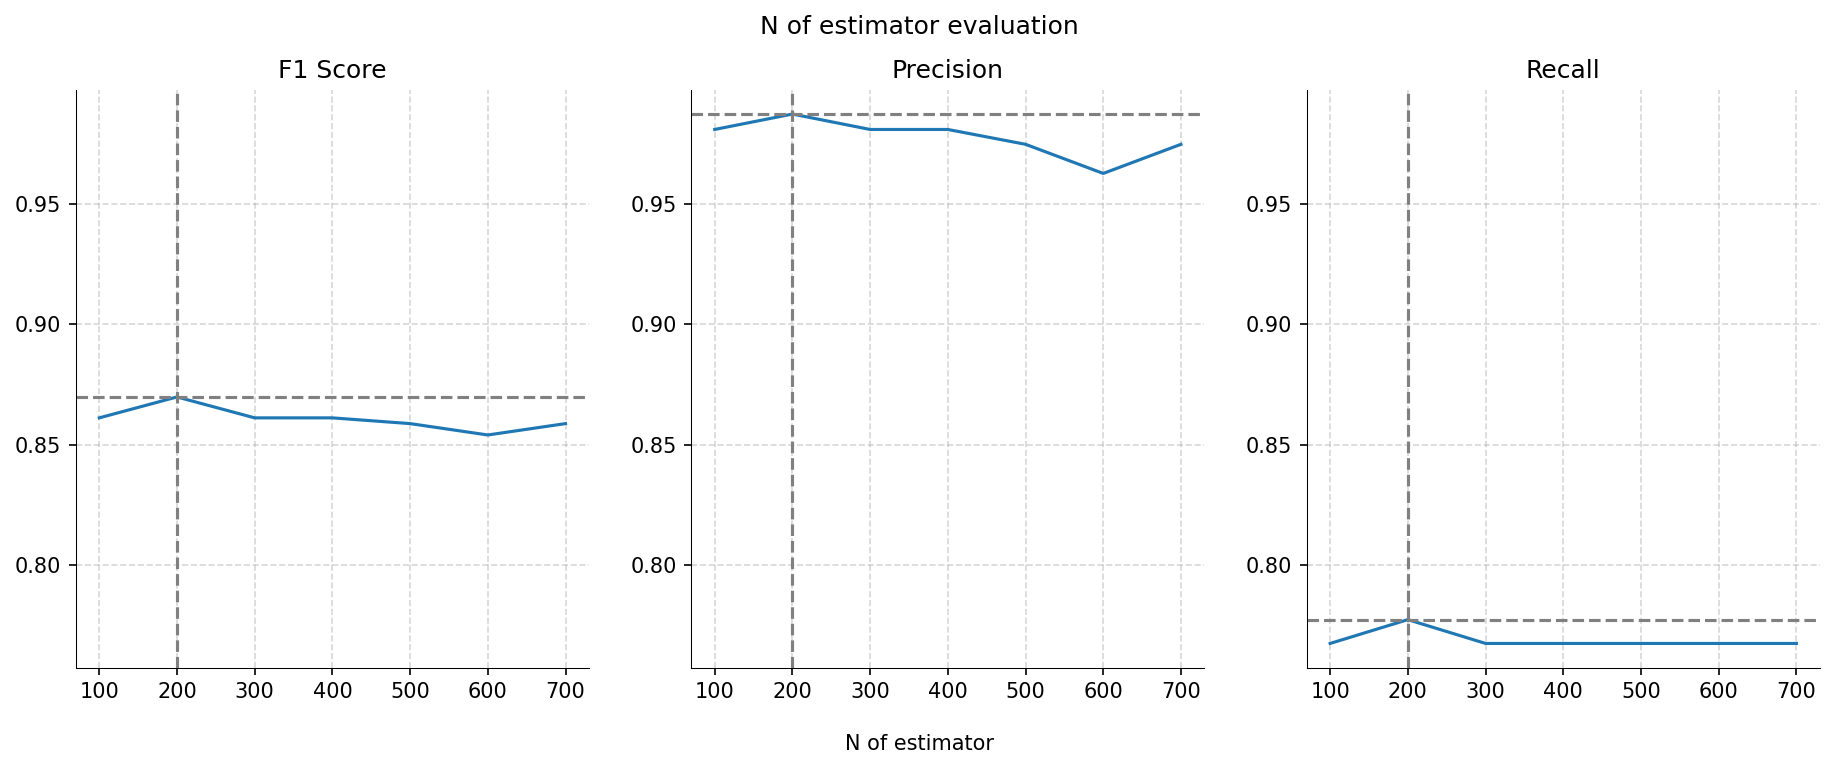

In [96]:
def elbow_scores(parameters,f1_list,precision_list,recall_list,parameter_name='N of estimator'):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
    axs =  axs.flatten()

    sns.lineplot(x=parameters,y=f1_list,ax=axs[0])
    sns.lineplot(x=parameters,y=precision_list,ax=axs[1])
    sns.lineplot(x=parameters,y=recall_list,ax=axs[2])

    axs[0].title.set_text('F1 Score')
    axs[1].title.set_text('Precision')
    axs[2].title.set_text('Recall')

    max_arg_f1 = np.argmax(f1_list)
    max_f1 = f1_list[max_arg_f1]

    max_arg_precision = np.argmax(precision_list)
    max_precision = precision_list[max_arg_precision]

    max_arg_recall = np.argmax(recall_list)
    max_recall = recall_list[max_arg_recall]

    all_arg_max = [max_arg_f1, max_arg_precision, max_arg_recall]
    all_max = [max_f1, max_precision, max_recall]

    y_min = np.min(f1_list + precision_list + recall_list) - 0.01
    y_max = np.max(f1_list + precision_list + recall_list) + 0.01

    y_range = [y_min, y_max]

    index = 0
    for ax in axs:
        ax.set_ylim(y_range)

        max_x = parameters[all_arg_max[index]]
        max_y = all_max[index]
        ax.axvline(max_x, color='gray', linestyle='dashed')
        ax.axhline(max_y, color='gray', linestyle='dashed')
        index += 1

    fig.suptitle(f'{parameter_name} evaluation')
    fig.text(0.5, 0, parameter_name, ha='center')
    plt.show()
    
elbow_scores(estimators,f1_list,precision_list,recall_list)

In [98]:
learning_rate = np.arange(0.25,2.5,0.25)

recall_list = []
precision_list = []
f1_list = []

for rate in learning_rate:
    AD_model = AdaBoostClassifier(random_state=42,n_estimators=200,learning_rate=rate)
    AD_model.fit(X_train,y_train)
    
    preds = AD_model.predict(X_val)
    
    recall_list.append(recall_score(y_val,preds))
    precision_list.append(precision_score(y_val,preds))
    f1_list.append(f1_score(y_val,preds))

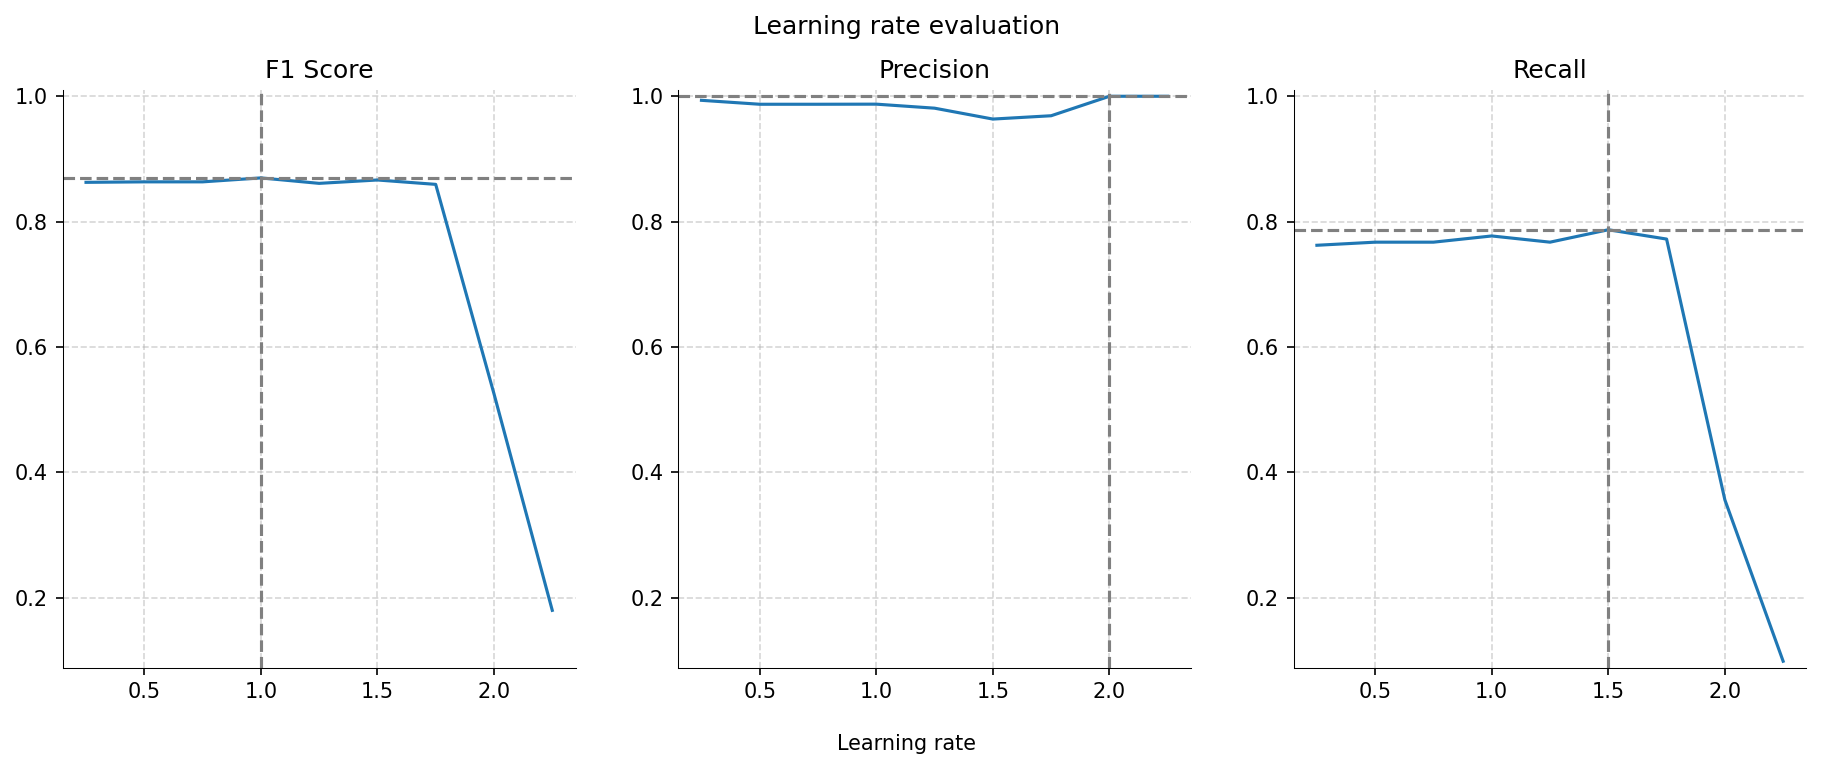

In [99]:
elbow_scores(learning_rate,f1_list,precision_list,recall_list,parameter_name='Learning rate')

In [29]:
AD_model_2 = AdaBoostClassifier(random_state=42,n_estimators=200,learning_rate=1)

models = [AD_model,AD_model_2]

comp_df = alg_ev_cross(models,X_train,y_train,cv=5)
comp_df['Tuned'] = ['No','Yes']
comp_df

,Algoritm,Training time,Accuracy,Balanced Accuracy,F1 score,Precision,Recall,Tuned
0,AdaBoostClassifier,7.685206,0.996134,0.88150,0.860521,0.987187,0.763158,No
1,AdaBoostClassifier,30.755467,0.996060,0.88175,0.858466,0.980569,0.763743,Yes


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13441
           1       0.99      0.78      0.87       202

    accuracy                           1.00     13643
   macro avg       0.99      0.89      0.93     13643
weighted avg       1.00      1.00      1.00     13643



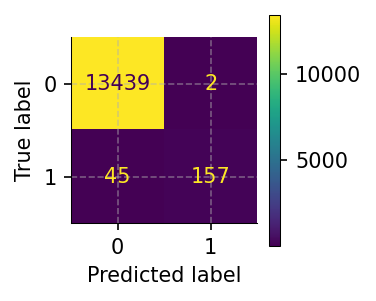

In [105]:
AD_model_2.fit(X_train,y_train)

preds = AD_model_2.predict(X_val)

print(classification_report(y_val,preds))
conf_matrix(y_val,preds)

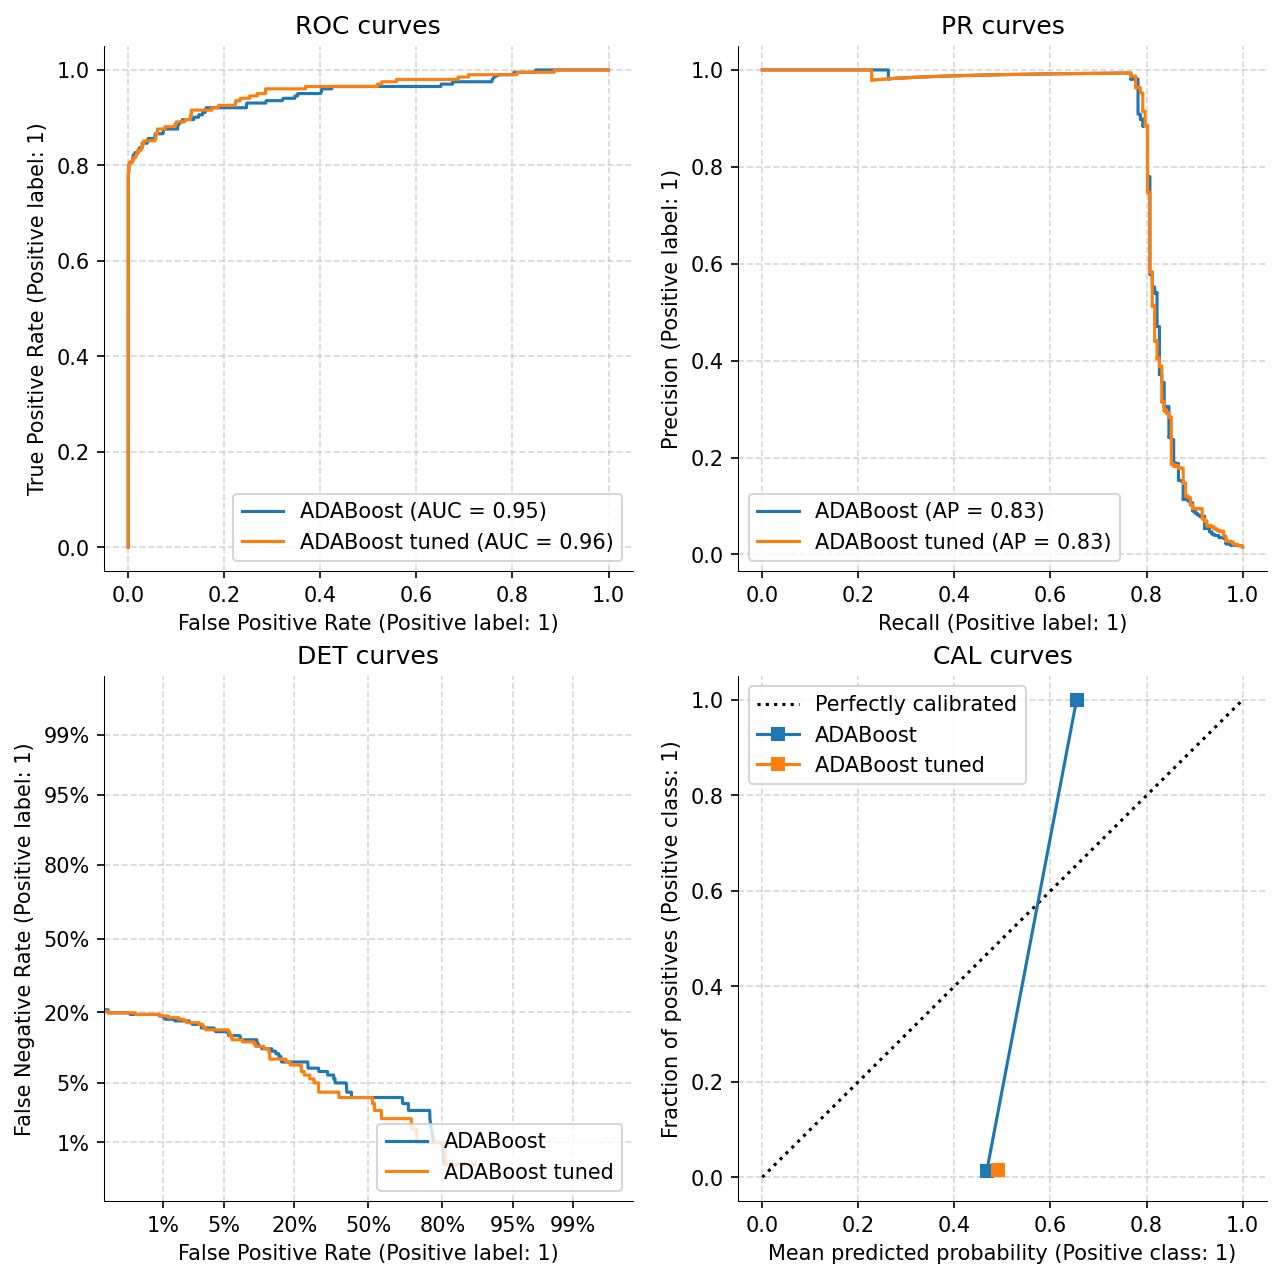

In [77]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay

def plot_roc_det(classifiers,X_val,y_val):
    """
    Plot ROC, Precision-Recall, DET, and Calibration curves for a set of classifiers.

    Parameters:
    classifiers (dict): Dictionary containing classifier names as keys and classifier (fitted) instances as values.
    X_val (pd.DataFrame): Validation dataset features.
    y_val (pd.Series): Validation dataset target.

    Returns:
    None
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs =  axs.flatten()

    for name, clf in classifiers.items():
        preds = clf.predict_proba(X_val)[:,1]

        RocCurveDisplay.from_predictions(y_val, preds, ax=axs[0], name=name)
        PrecisionRecallDisplay.from_predictions(y_val, preds, ax=axs[1], name=name)
        DetCurveDisplay.from_predictions(y_val, preds, ax=axs[2], name=name)
        CalibrationDisplay.from_predictions(y_val, preds, ax=axs[3], name=name)

    axs[0].set_title("ROC curves")
    axs[1].set_title("PR curves")
    axs[2].set_title("DET curves")
    axs[3].set_title("CAL curves")

    plt.legend()
    plt.show()
    
classifiers = {
    'ADABoost': AD_model,
    'ADABoost tuned': AD_model_2
}

plot_roc_det(classifiers,X_val,y_val)

### 4.2.3 ADA Boost with weights (try to balance clases)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     13441
           1       0.25      0.84      0.38       202

    accuracy                           0.96     13643
   macro avg       0.62      0.90      0.68     13643
weighted avg       0.99      0.96      0.97     13643



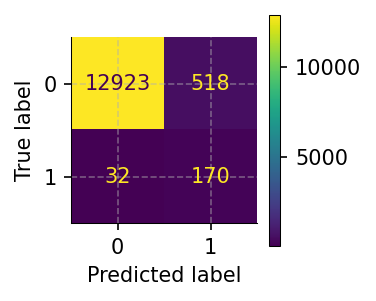

In [104]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weight = compute_sample_weight(class_weight='balanced',y=y_train)

AD_model_3 = AdaBoostClassifier(random_state=42,n_estimators=200,learning_rate=1)
AD_model_3.fit(X_train,y_train,sample_weight=sample_weight)

preds = AD_model_3.predict(X_val)
print(classification_report(y_val,preds))
conf_matrix(y_val,preds)

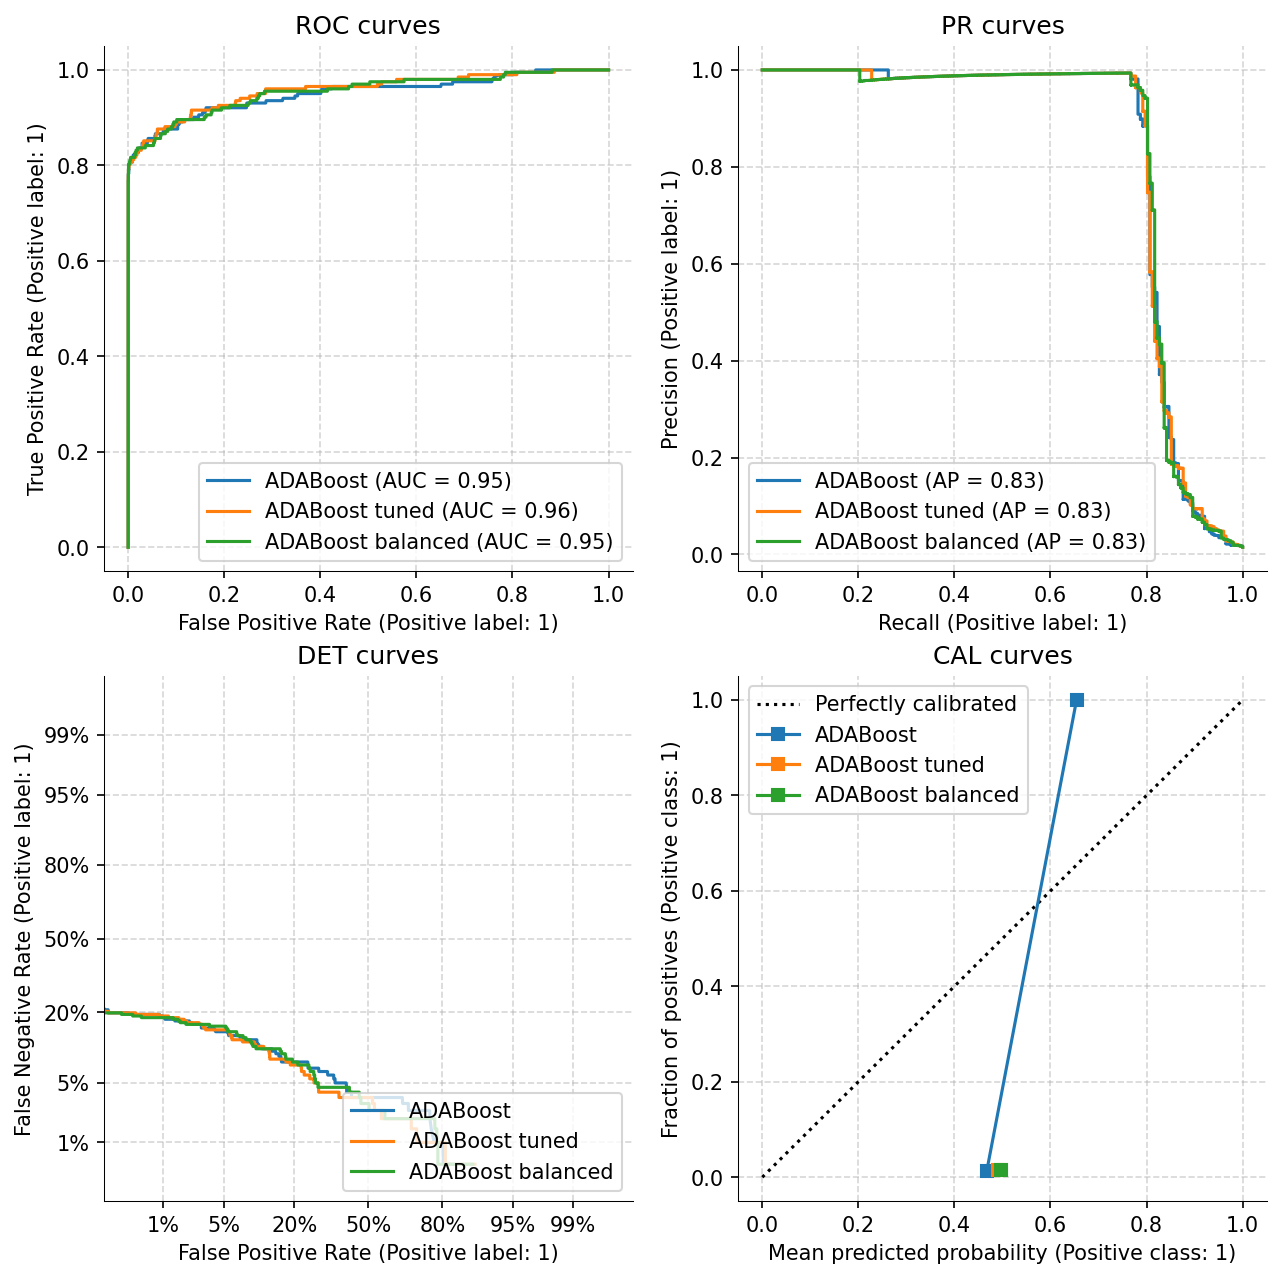

In [43]:
classifiers['ADABoost balanced'] = AD_model_3
plot_roc_det(classifiers,X_val,y_val)

### 4.2.4- XGBoost baseline

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13441
           1       0.98      0.78      0.87       202

    accuracy                           1.00     13643
   macro avg       0.99      0.89      0.93     13643
weighted avg       1.00      1.00      1.00     13643



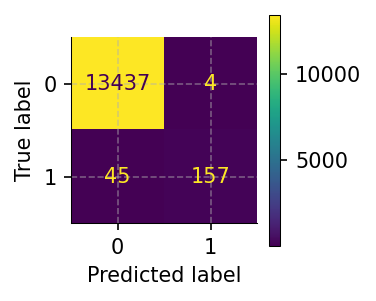

In [103]:
XG_model.fit(X_train,y_train)

preds = XG_model.predict(X_val)
print(classification_report(y_val,preds))
conf_matrix(y_val,preds)

### 4.2.5- XGBoost hyperparamenter tuning (Bayesian optimization)

In [129]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {
    'n_estimators': hp.uniform ('n_estimators', 50,250),
    'max_depth': hp.quniform("max_depth", 3, 25, 1),
    'gamma': hp.uniform ('gamma', 1,5),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.4,1),
    #'reg_alpha' : hp.quniform('reg_alpha', 10,45,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'random_state': 42
}

def objective(space):
    XGB_clf = XGBClassifier(
        n_estimators = int(space['n_estimators']),
        max_depth = int(space['max_depth']),
        gamma = space['gamma'],
        colsample_bytree = int(space['colsample_bytree']),
        reg_lambda = int(space['reg_lambda']),
        min_child_weight = int(space['min_child_weight']),
        random_state = space['random_state']
    )
    
    score = cross_val_score(XGB_clf,X_train,y_train,cv=5,scoring='f1')
    score = np.mean(score)
    
    print('SCORE: ',score)
    return {'loss': 1 - score, 'status': STATUS_OK}

In [130]:
trials = Trials()

best_params = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=100,trials=trials)

SCORE:                                                 
0.8392544767418325                                     
SCORE:                                                                           
0.8482358436078444                                                               
SCORE:                                                                            
0.8579050481296292                                                                
SCORE:                                                                            
0.7684541199737345                                                               
SCORE:                                                                           
0.8579522365734416                                                               
SCORE:                                                                            
0.8060554060004337                                                                
SCORE:                                                         

0.8497049995993049                                                                 
SCORE:                                                                             
0.8045872878934912                                                                 
SCORE:                                                                             
0.8601013866475438                                                                 
SCORE:                                                                              
0.8615647897995465                                                                  
SCORE:                                                                              
0.8599430161042358                                                                  
SCORE:                                                                              
0.8559462074897939                                                                  
SCORE:                                                                

In [128]:
best_params

{'colsample_bytree': 0.6629204752126748,
 'gamma': 2.8619655891203752,
 'max_depth': 18.0,
 'min_child_weight': 4.0,
 'n_estimators': 192.0151373878645,
 'reg_alpha': 10.0,
 'reg_lambda': 0.629745885931746}

In [131]:
best_params

{'colsample_bytree': 0.48278853482586565,
 'gamma': 3.1544797990898688,
 'max_depth': 3.0,
 'min_child_weight': 2.0,
 'n_estimators': 160.66408710550076,
 'reg_lambda': 0.9215303383104446}

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13441
           1       0.99      0.78      0.87       202

    accuracy                           1.00     13643
   macro avg       0.99      0.89      0.94     13643
weighted avg       1.00      1.00      1.00     13643



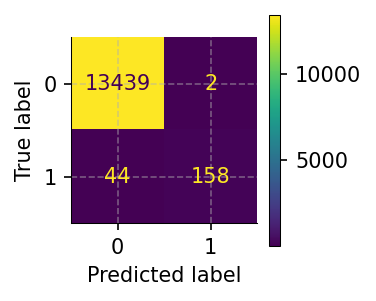

In [33]:
params = {
    'colsample_bytree': 0.48278853482586565,
    'gamma': 3.1544797990898688,
    'max_depth': 18,
    'min_child_weight': 2.0,
    'n_estimators': int(192.0151373878645),
    'reg_lambda': 0.9215303383104446,
    'random_state': 42}

XG_model_2 = XGBClassifier(
    n_estimators = params['n_estimators'],
    max_depth = params['max_depth'],
    gamma = params['gamma'],
    colsample_bytree = params['colsample_bytree'],
    reg_lambda = params['reg_lambda'],
    min_child_weight = params['min_child_weight'],
    random_state = params['random_state']
    )

XG_model_2.fit(X_train,y_train)

preds = XG_model_2.predict(X_val)
print(classification_report(y_val,preds))
conf_matrix(y_val,preds)

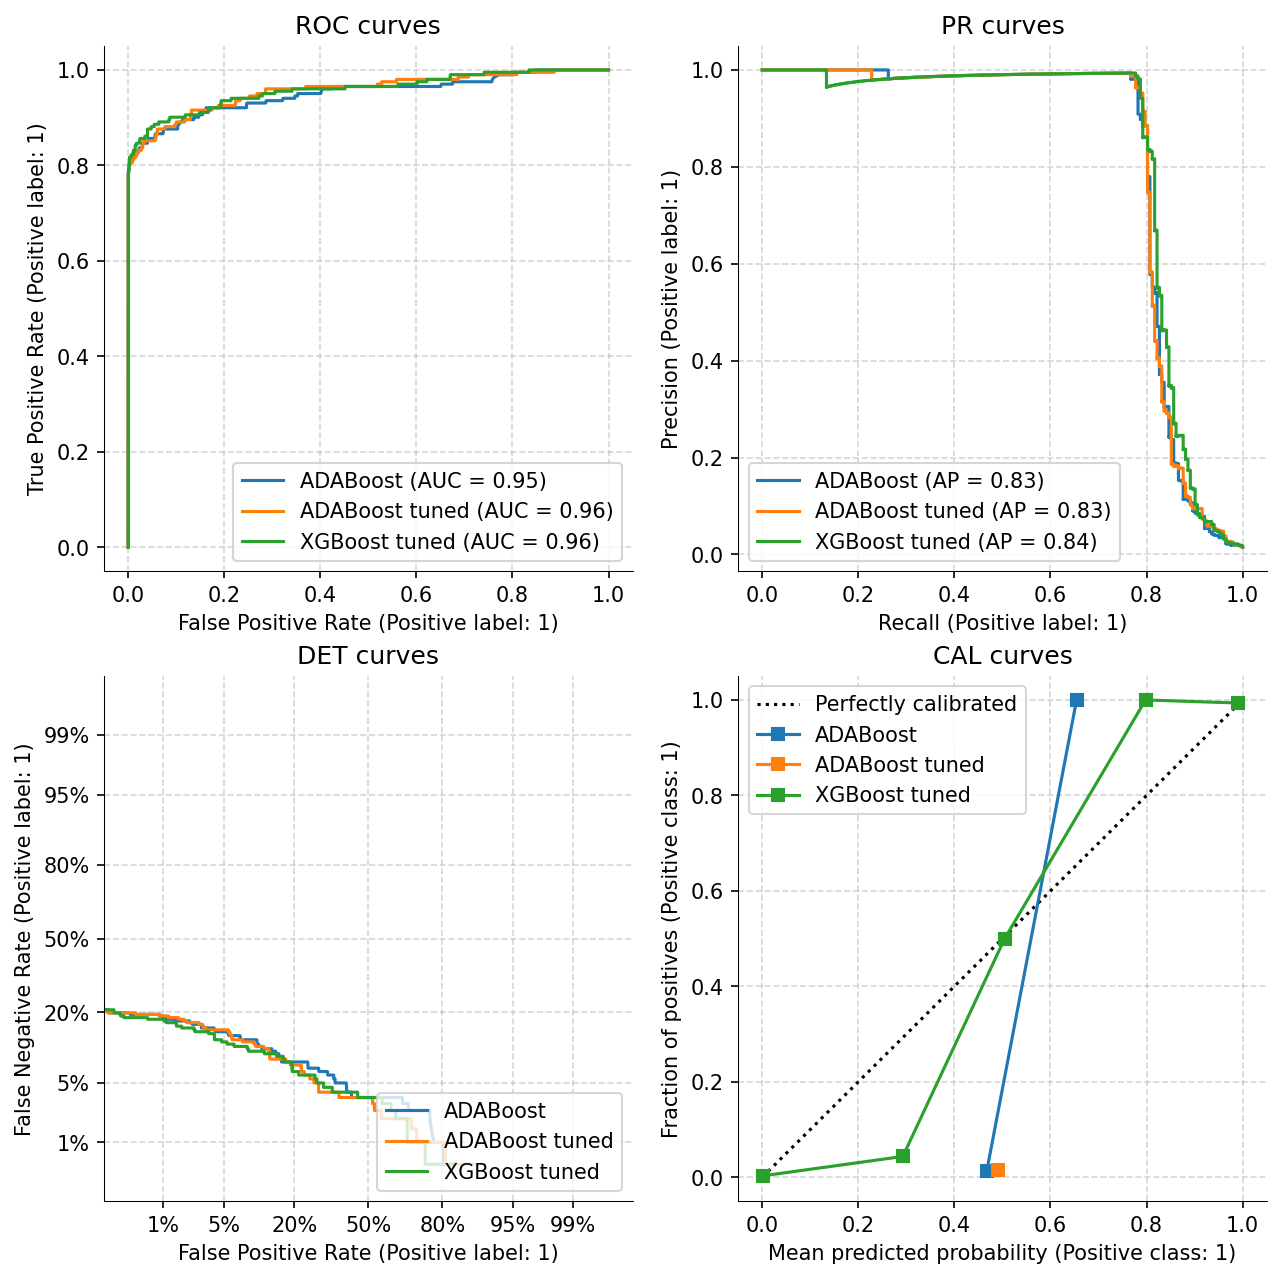

In [151]:
classifiers['XGBoost tuned'] = XG_model_2
plot_roc_det(classifiers,X_val,y_val)

# 5- Feature importance and selection

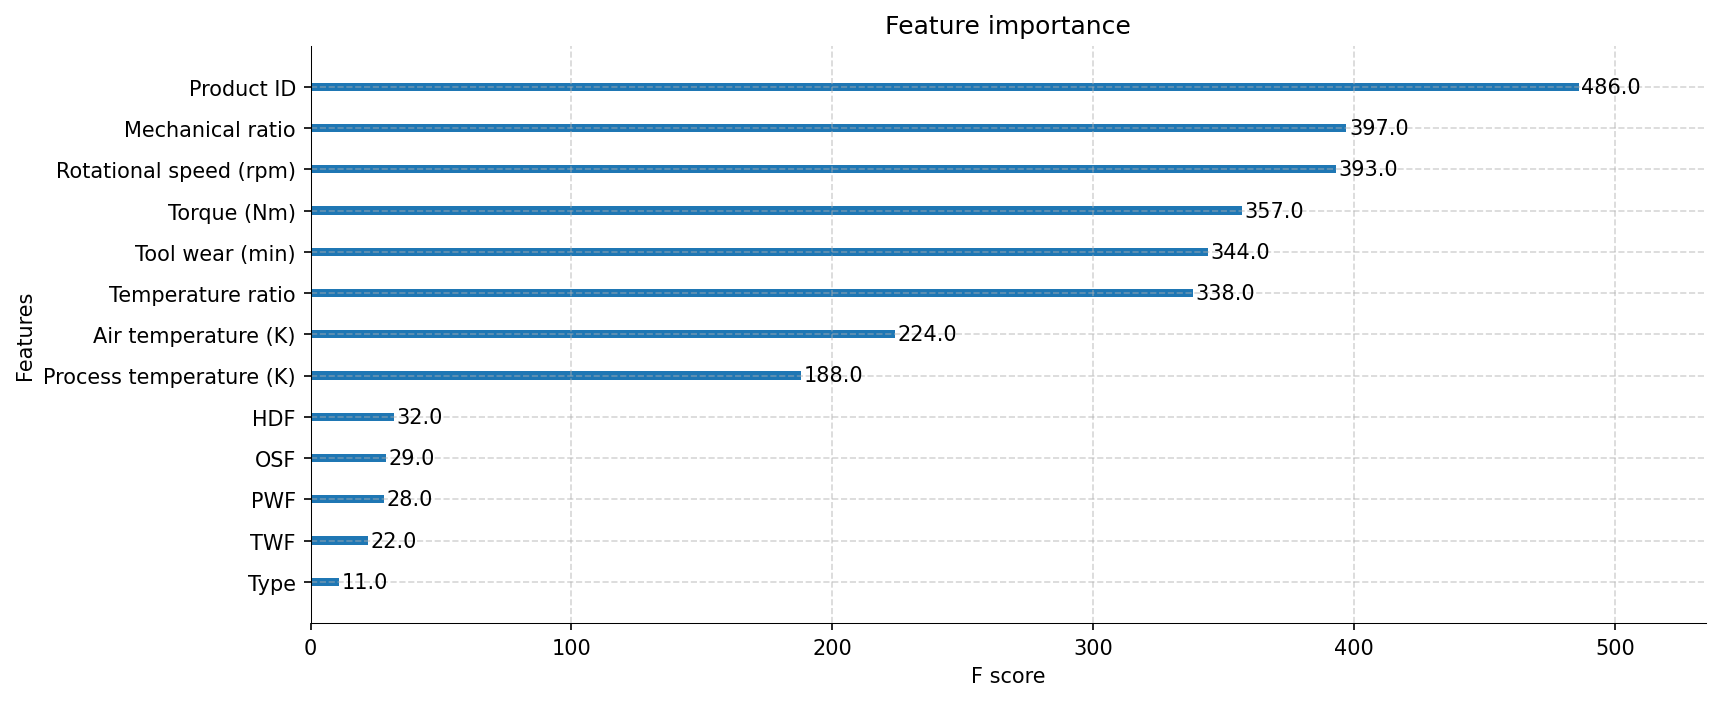

In [53]:
from xgboost import plot_importance

plot_importance(XG_model_2)
plt.show()

In [58]:
shap.initjs()
explainer = shap.TreeExplainer(model=XG_model_2)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


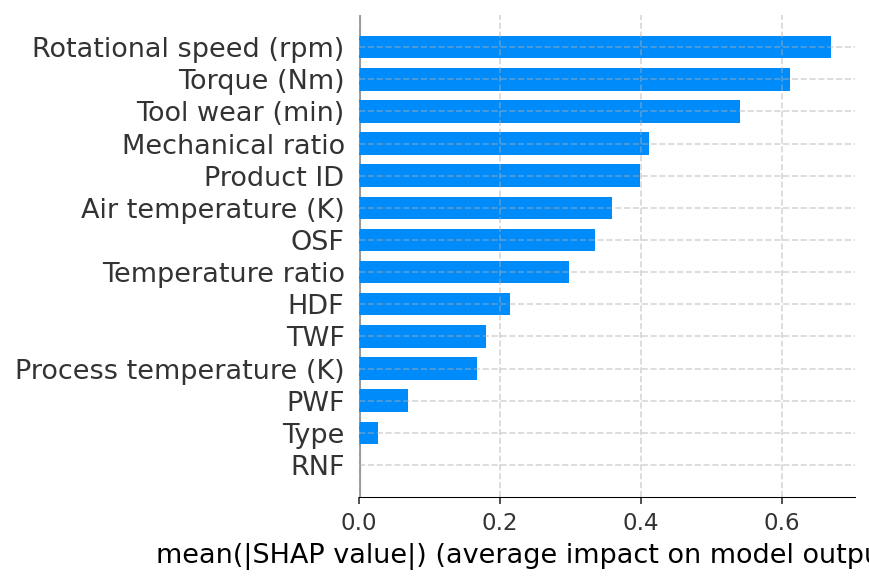

In [70]:
shap.summary_plot(shap_values,X_train,plot_type="bar",plot_size=[6,4])

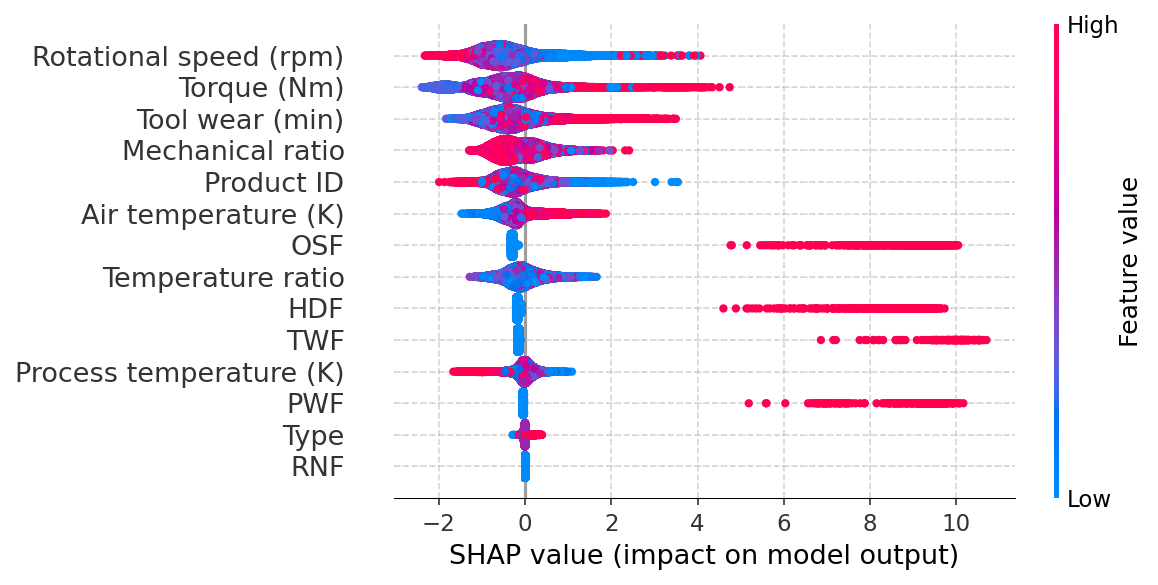

In [72]:
shap.summary_plot(shap_values,X_train,plot_size=[8,4])

In [90]:
from sklearn.metrics import recall_score, precision_score, f1_score
from numpy import sort

feats = ['RNF','Type','TWF','PWF']
drop = []

for feat in feats:
    
    drop.append(feat)
    select_X_train = X_train.drop(drop,axis=1)
    select_X_val = X_val.drop(drop,axis=1)
    
    model = XGBClassifier(
    n_estimators = params['n_estimators'],
    max_depth = params['max_depth'],
    gamma = params['gamma'],
    colsample_bytree = params['colsample_bytree'],
    reg_lambda = params['reg_lambda'],
    min_child_weight = params['min_child_weight'],
    random_state = params['random_state'])
    
    model.fit(select_X_train,y_train)
    
    preds =  model.predict(select_X_val)
    
    recall = round(recall_score(y_val,preds),2)
    precision = round(precision_score(y_val,preds),2)
    f1 = round(f1_score(y_val,preds),2)
    
    print(f'Eliminated Features: {drop}\nrecall: {recall}, precision: {precision}, f1: {f1}')

Eliminated Features: ['RNF']
recall: 0.78, precision: 0.99, f1: 0.87
Eliminated Features: ['RNF', 'Type']
recall: 0.77, precision: 0.98, f1: 0.86
Eliminated Features: ['RNF', 'Type', 'TWF']
recall: 0.7, precision: 0.95, f1: 0.81
Eliminated Features: ['RNF', 'Type', 'TWF', 'PWF']
recall: 0.64, precision: 0.91, f1: 0.75


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13441
           1       0.99      0.78      0.87       202

    accuracy                           1.00     13643
   macro avg       0.99      0.89      0.93     13643
weighted avg       1.00      1.00      1.00     13643



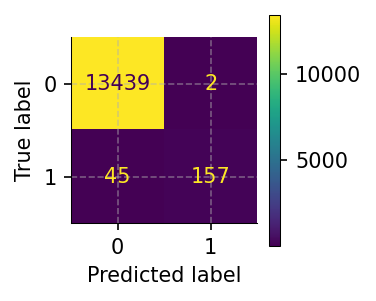

In [93]:
drop_feat = ['RNF']

XG_model_3 = XGBClassifier(
    n_estimators = params['n_estimators'],
    max_depth = params['max_depth'],
    gamma = params['gamma'],
    colsample_bytree = params['colsample_bytree'],
    reg_lambda = params['reg_lambda'],
    min_child_weight = params['min_child_weight'],
    random_state = params['random_state'])

XG_model_3.fit(X_train.drop(drop_feat,axis=1),y_train)

preds = XG_model_3.predict(X_val.drop(drop_feat,axis=1))
print(classification_report(y_val,preds))
conf_matrix(y_val,preds)

# 6- Out of sample evaluation (Final model)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13407
           1       0.98      0.78      0.87       236

    accuracy                           1.00     13643
   macro avg       0.99      0.89      0.93     13643
weighted avg       1.00      1.00      1.00     13643



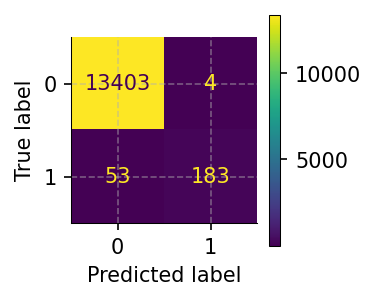

In [94]:
preds = XG_model_3.predict(X_test.drop(drop_feat,axis=1))
print(classification_report(y_test,preds))
conf_matrix(y_test,preds)